<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_06_1_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 6: Advanced Topics**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 6 Material

* **Part 6.1: Reinforcement Learning**
* Part 6.2: ONNX Runtime Environment
* Part 6.3: Analysis of DICOM images with Pytorch

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [ ]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    COLAB = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.

![__](https://biologicslab.co/BIO1173/images/class_04/class_04_1_image01B.png)

If your GMAIL address does not appear your lesson will **not** be graded.

# **Reinforcement Learning**

This Colab notebook provides a simplified example of a reinforcement learning
(RL) agent for a common biostatistics scenario:  Optimizing a treatment strategy.
The goal is to demonstrate the core concepts of RL in an accessible way.

**Scenario:**

Imagine we're designing a treatment plan for patients with a certain condition.
The treatment involves adjusting the dosage of a drug over time. The patient's
condition is observed through a measurable biomarker. The goal is to find the
optimal dosage adjustment strategy to keep the biomarker within a desired range.

**Simplifications:**

*   Discrete state space: The biomarker level is discretized into a limited number of states.
*   Discrete action space:  Dosage adjustments are also discrete (increase, decrease, maintain).
*   Simple reward function:  Reward is high when biomarker is in the target range, low otherwise.
*   Deterministic environment: For simplicity, we assume the biomarker change is predictable given the current state and action.  (This is *unrealistic* for real-world biostatistics, but simplifies the example).
*   Q-learning: We'll use Q-learning, a basic RL algorithm, for learning.

**Learning Objectives:**

*   Understand the core components of RL: Agent, Environment, State, Action, Reward.
*   Grasp the concept of a Q-table and how it's updated.
*   See how an RL agent can learn to make decisions based on experience (simulated in this case).





In [ ]:
def reset_environment():
    """Reset the environment to a random initial state."""
    global current_state
    current_state = int(np.random.choice(np.arange(state_space_size), p=initial_state_prob))
    return current_state

def step_environment(action):
    """
    Simulates the environment's response to an action. Returns next state, reward, and done flag.
    Action: 0 = Decrease dosage, 1 = Maintain dosage, 2 = Increase dosage
    """
    global current_state

    # Simplification: Deterministic state transitions based on action
    if action == 0:  # Decrease dosage
        next_state = max(0, current_state - 1)  # Ensure state stays within bounds
    elif action == 1: # Maintain dosage
        next_state = current_state
    else:  # Increase dosage
        next_state = min(state_space_size - 1, current_state + 1)  # Ensure state stays within bounds

    current_state = next_state

    # Reward function: High reward when biomarker is in the target range
    def state_to_biomarker(state):
        """Maps a discrete state to a continuous biomarker value (for reward calculation)."""
        # Linear mapping: State 0 -> 0, State (n-1) -> 100
        return (state / (state_space_size - 1)) * 100

    biomarker_value = state_to_biomarker(current_state)
    if target_range[0] <= biomarker_value <= target_range[1]:
        reward = 10  # Positive reward for being in the target range
    else:
        reward = -1   # Negative reward for being outside the target range

    done = False  # In this example, the episode never ends

    return next_state, reward, done

def render_environment():
    """Prints the current state in a human-readable format."""
    def state_to_biomarker(state):
        """Maps a discrete state to a continuous biomarker value (for reward calculation)."""
        return (state / (state_space_size - 1)) * 100

    biomarker_value = state_to_biomarker(current_state)
    print(f"Current Biomarker Level: {biomarker_value:.2f}")

### Example 1: Define the Environment

In [ ]:
# Example 1: Define the Environment

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set environmental parameters
target_range = (40, 60)
state_space_size = 5
action_space_size = 3
initial_state_prob = [0.1, 0.2, 0.4, 0.2, 0.1]

# Set up initial state probability distribution
if initial_state_prob is None:
    initial_state_prob = np.ones(state_space_size) / state_space_size  # Uniform
else:
    initial_state_prob = np.array(initial_state_prob)
    initial_state_prob /= np.sum(initial_state_prob)  # Ensure normalization

print("Environment parameters:")
print(f"Target range: {target_range}")
print(f"State space size: {state_space_size}")
print(f"Action space size: {action_space_size}")
print(f"Initial state probabilities: {initial_state_prob}")

# Initialize current state
current_state = int(np.random.choice(np.arange(state_space_size), p=initial_state_prob))
print(f"Initial state: {current_state}")

# Test the environment
print("\nTesting the environment:")
reset_environment()
render_environment()
next_state, reward, done = step_environment(1)  # Maintain dosage
print(f"After action 'Maintain': state={next_state}, reward={reward}")
render_environment()

Environment parameters:
Target range: (40, 60)
State space size: 5
Action space size: 3
Initial state probabilities: [0.1 0.2 0.4 0.2 0.1]
Initial state: 0

Testing the environment:
Current Biomarker Level: 0.00
After action 'Maintain': state=0, reward=-1
Current Biomarker Level: 0.00


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image01A.png)

### Example 2: Define the Agent (Q-Learning)

In [ ]:
# Example 2: Define the Agent (Q-Learning)

# Set Q-learning agent parameters
learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 0.1

# Initialize Q-table with zeros
q_table = np.zeros((state_space_size, action_space_size))
print(f"Q-Table shape: {q_table.shape}")
print("Initial Q-table:")
print(q_table)

# Track rewards during training
training_history = []

def choose_action(state):
    """Chooses an action using an epsilon-greedy policy."""
    if random.uniform(0, 1) < exploration_rate:
        # Explore: Choose a random action
        return random.choice(range(action_space_size))
    else:
        # Exploit: Choose the action with the highest Q-value for the current state
        return np.argmax(q_table[state, :])

def learn(state, action, reward, next_state):
    """Updates the Q-table using the Q-learning update rule."""
    global q_table

    best_next_action = np.argmax(q_table[next_state, :])  # Find the best action for the NEXT state
    td_target = reward + discount_factor * q_table[next_state, best_next_action]  # Calculate the TD target
    td_error = td_target - q_table[state, action]  # Calculate the TD error
    q_table[state, action] += learning_rate * td_error  # Update the Q-value

    # Store reward for visualization
    training_history.append(reward)

# Test the agent with one episode
print("\nTesting the agent:")
reset_environment()
for i in range(5):
    current_state = env.state if 'env' in locals() else reset_environment()
    action = choose_action(current_state)
    next_state, reward, done = step_environment(action)  # Take a step in the environment
    learn(current_state, action, reward, next_state)  # Update the Q-table

print("Q-table after one episode:")
print(q_table)

Q-Table shape: (5, 3)
Initial Q-table:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Testing the agent:
Q-table after one episode:
[[-0.1  -0.1   0.  ]
 [-0.19  0.   -0.1 ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image02A.png)

### Example 3: Training Loop

In [ ]:
# Example 3: Training Loop with Visualization

# Training parameters
num_episodes = 1000

def train_agent():
    """Trains the agent in the environment and tracks training progress."""
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = reset_environment()  # Reset the environment at the beginning of each episode
        total_reward = 0

        # Simulate a fixed number of steps within each episode (e.g., 10 steps)
        for _ in range(10):  # Example: Each episode consists of 10 steps
            action = choose_action(state)
            next_state, reward, done = step_environment(action)  # Take a step in the environment
            learn(state, action, reward, next_state)  # Update the Q-table
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}")

    print("Training complete.")
    return rewards_per_episode

# Run training (this might take a few moments)
rewards_history = train_agent()

print("\nFinal Q-Table:")
print(q_table)



Episode: 0, Total Reward: 100
Episode: 100, Total Reward: 100
Episode: 200, Total Reward: 89
Episode: 300, Total Reward: 89
Episode: 400, Total Reward: 89
Episode: 500, Total Reward: 89
Episode: 600, Total Reward: 89
Episode: 700, Total Reward: 78
Episode: 800, Total Reward: 89
Episode: 900, Total Reward: 100
Training complete.

Final Q-Table:
[[ 50.0538186   43.25378796  88.99999999]
 [ 77.50728205  84.07915471 100.        ]
 [ 89.         100.          89.        ]
 [100.          86.89001838  73.5426718 ]
 [ 88.99999999  54.80846466  39.32336609]]


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image03A.png)

### Example 4: Visualize Training


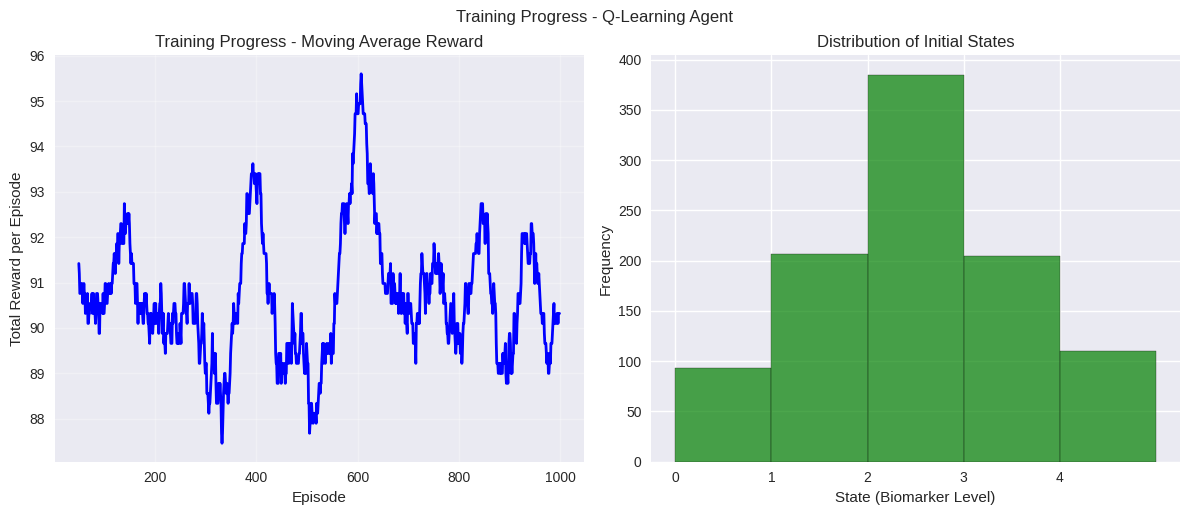

In [ ]:
# Example 4: Visualize Training

# Create functions
def eg_plot_training_progress(rewards_history, title="Training Progress"):
    """Plot the training progress over episodes."""
    plt.figure(figsize=(12, 5))

    # Plot 1: Reward per episode (moving average)
    plt.subplot(1, 2, 1)
    window_size = max(10, len(rewards_history) // 20)  # Adaptive window size
    if len(rewards_history) >= window_size:
        moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(rewards_history)), moving_avg, 'b-', linewidth=2)
        plt.title('Training Progress - Moving Average Reward')
    else:
        plt.plot(rewards_history, 'b-', linewidth=2)
        plt.title('Training Progress')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward per Episode')
    plt.grid(True, alpha=0.3)

    # Plot 2: Distribution of final states
    plt.subplot(1, 2, 2)
    final_states = []
    for _ in range(1000):  # Sample many states
        reset_environment()
        state = current_state
        final_states.append(state)

    plt.hist(final_states, bins=range(state_space_size + 1), alpha=0.7, color='green', edgecolor='black')
    plt.title('Distribution of Initial States')
    plt.xlabel('State (Biomarker Level)')
    plt.ylabel('Frequency')
    plt.xticks(range(state_space_size))

    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# Plot training progress
eg_plot_training_progress(rewards_history, "Training Progress - Q-Learning Agent")

If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image04A.png)

### Example 5: Visualization Functions - Part 1

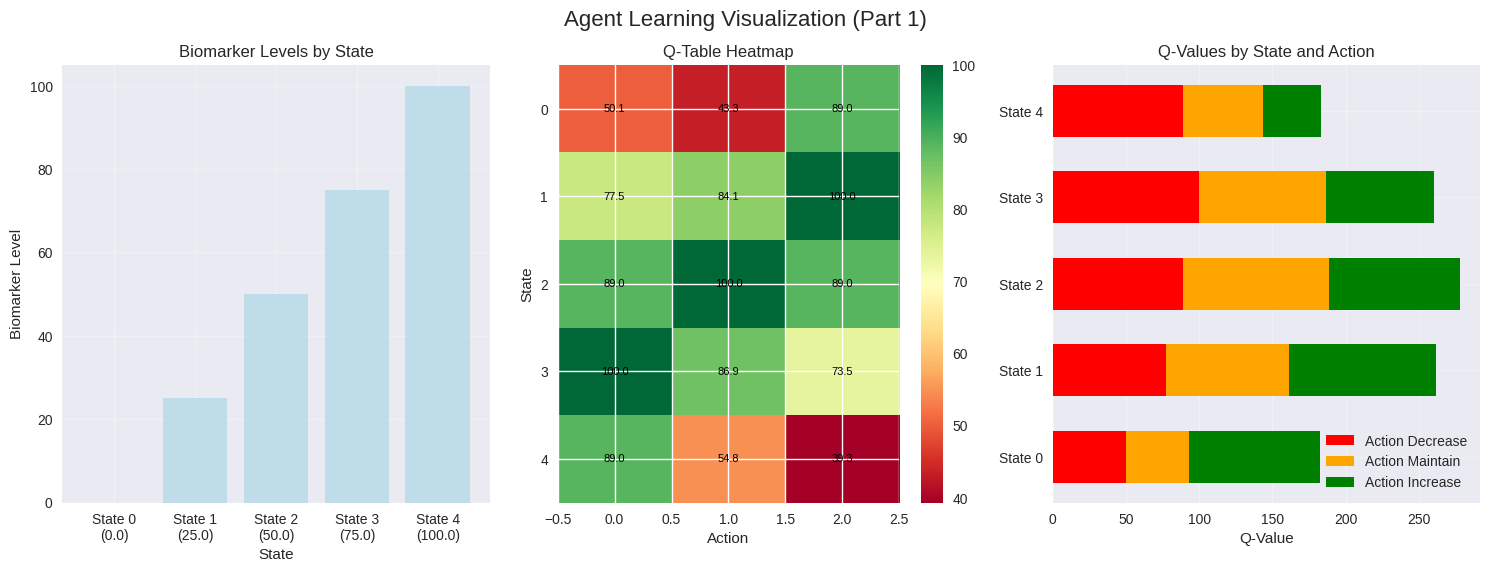

In [ ]:
# Example 5: Visualization Functions - Part 1

def visualize_policy_and_qtable_part1():


    """Create first half of comprehensive visualization of the learned policy."""
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Policy Visualization
    ax1 = plt.subplot(2, 3, 1)
    biomarker_levels = [i * (100 / (state_space_size - 1)) for i in range(state_space_size)]
    actions = ['Decrease', 'Maintain', 'Increase']

    # Get recommended action for each state
    policy_actions = []
    q_values = []

    for i in range(state_space_size):
        best_action = np.argmax(q_table[i, :])
        policy_actions.append(best_action)
        q_values.append(q_table[i, :])

    bars = ax1.bar(range(len(biomarker_levels)), biomarker_levels, color='lightblue', alpha=0.7)
    ax1.set_xlabel('State')
    ax1.set_ylabel('Biomarker Level')
    ax1.set_title('Biomarker Levels by State')
    ax1.set_xticks(range(len(biomarker_levels)))
    ax1.set_xticklabels([f'State {i}\n({biomarker_levels[i]:.1f})' for i in range(len(biomarker_levels))])

    # Add grid
    ax1.grid(True, alpha=0.3)

    # Plot 2: Q-Table Heatmap
    ax2 = plt.subplot(2, 3, 2)
    q_table_array = np.array(q_table)
    im = ax2.imshow(q_table_array, cmap='RdYlGn', aspect='auto')
    ax2.set_title('Q-Table Heatmap')
    ax2.set_xlabel('Action')
    ax2.set_ylabel('State')

    # Add text annotations
    for i in range(state_space_size):
        for j in range(action_space_size):
            ax2.text(j, i, f'{q_table_array[i,j]:.1f}',
                    ha='center', va='center', color='black', fontsize=8)

    plt.colorbar(im, ax=ax2)

    # Plot 3: Policy Decision Matrix
    ax3 = plt.subplot(2, 3, 3)
    action_colors = ['red', 'orange', 'green']
    y_pos = np.arange(state_space_size)

    for i in range(action_space_size):
        values = [q_table[j, i] for j in range(state_space_size)]
        ax3.barh(y_pos, values, left=np.sum(q_table[:, :i], axis=1) if i > 0 else 0,
                height=0.6, label=f'Action {actions[i]}', color=action_colors[i])

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([f'State {i}' for i in range(state_space_size)])
    ax3.set_xlabel('Q-Value')
    ax3.set_title('Q-Values by State and Action')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Agent Learning Visualization (Part 1)', y=1.02, fontsize=16)
    plt.show()

# Visualize first half of policy and q-table
visualize_policy_and_qtable_part1()


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image05A.png)

### Example 5: Visualization Functions - Part 2

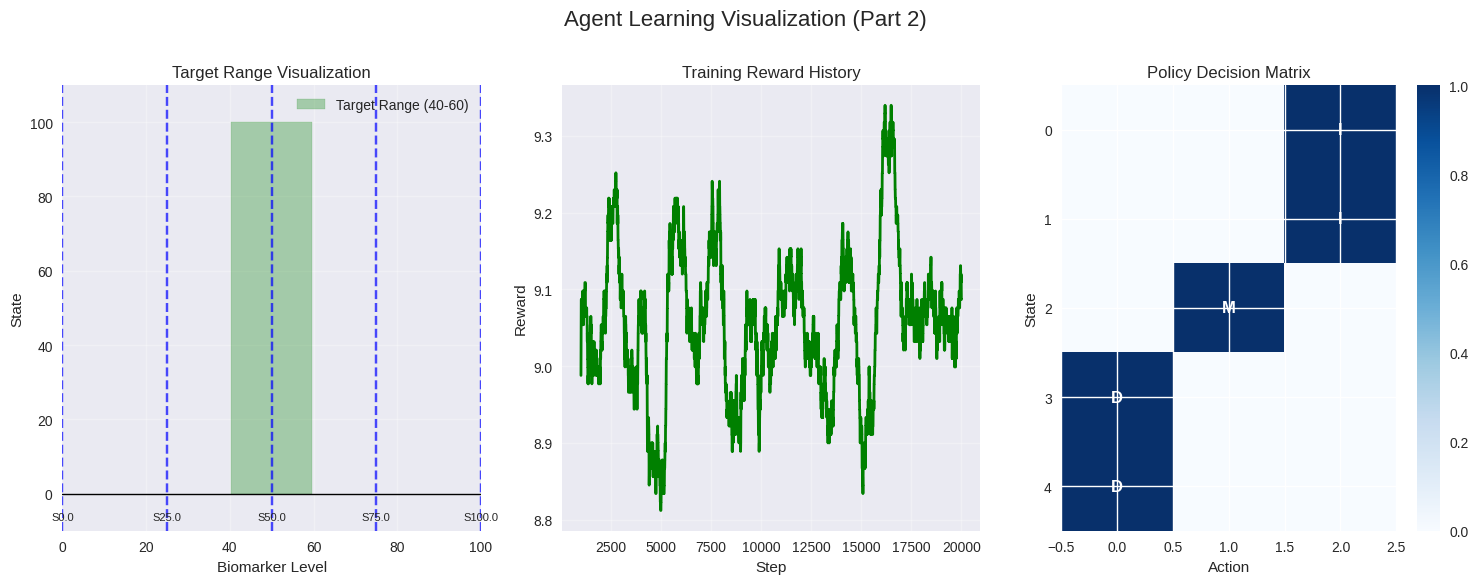

In [ ]:
# Example 5: Visualization Functions - Part 2


def visualize_policy_and_qtable_part2():
    """Create second half of comprehensive visualization of the learned policy."""
    fig = plt.figure(figsize=(15, 10))

    # Define actions again to avoid NameError
    actions = ['Decrease', 'Maintain', 'Increase']

    # Plot 4: Target Range Visualization
    ax4 = plt.subplot(2, 3, 4)
    x_values = np.linspace(0, 100, 100)
    target_range_local = target_range

    # Plot target range area
    ax4.fill_between(x_values, 0, 100, where=(x_values >= target_range_local[0]) & (x_values <= target_range_local[1]),
                    alpha=0.3, color='green', label=f'Target Range ({target_range_local[0]}-{target_range_local[1]})')
    ax4.plot(x_values, [0]*len(x_values), 'k-', linewidth=1)

    # Add vertical lines for state boundaries
    for i in range(state_space_size):
        biomarker_value = i * (100 / (state_space_size - 1))
        ax4.axvline(biomarker_value, color='blue', linestyle='--', alpha=0.7)
        ax4.text(biomarker_value, -5, f'S{biomarker_value:.1f}',
                ha='center', va='top', fontsize=8)

    ax4.set_xlim(0, 100)
    ax4.set_ylim(-10, 110)
    ax4.set_xlabel('Biomarker Level')
    ax4.set_ylabel('State')
    ax4.set_title('Target Range Visualization')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: Reward History
    ax5 = plt.subplot(2, 3, 5)
    if len(training_history) > 0:
        window_size = max(10, len(training_history) // 20)
        if len(training_history) >= window_size:
            moving_avg = np.convolve(training_history, np.ones(window_size)/window_size, mode='valid')
            ax5.plot(range(window_size-1, len(training_history)), moving_avg, 'g-', linewidth=2)
        else:
            ax5.plot(training_history, 'g-', linewidth=2)
        ax5.set_title('Training Reward History')
        ax5.set_xlabel('Step')
        ax5.set_ylabel('Reward')
        ax5.grid(True, alpha=0.3)

    # Plot 6: Policy Summary
    ax6 = plt.subplot(2, 3, 6)
    policy_summary = []
    for i in range(state_space_size):
        action_idx = np.argmax(q_table[i, :])
        biomarker_value = i * (100 / (state_space_size - 1))

        # Determine if state is within target range
        in_target = target_range[0] <= biomarker_value <= target_range[1]
        policy_summary.append((i, biomarker_value, actions[action_idx], in_target))

    # Create a heatmap of the policy decision matrix
    policy_matrix = np.zeros((state_space_size, action_space_size))
    for i in range(state_space_size):
        best_action = np.argmax(q_table[i, :])
        policy_matrix[i, best_action] = 1

    im2 = ax6.imshow(policy_matrix, cmap='Blues', aspect='auto')
    ax6.set_title('Policy Decision Matrix')
    ax6.set_xlabel('Action')
    ax6.set_ylabel('State')

    # Add text annotations
    for i in range(state_space_size):
        for j in range(action_space_size):
            if policy_matrix[i, j] > 0.5:
                ax6.text(j, i, actions[j][0],
                        ha='center', va='center', color='white', fontsize=12, fontweight='bold')

    plt.colorbar(im2, ax=ax6)

    plt.tight_layout()
    plt.suptitle('Agent Learning Visualization (Part 2)', y=0.58, fontsize=16)
    plt.show()

# Visualize second half of policy and q-table
visualize_policy_and_qtable_part2()


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image06A.png)

### Example 6: Biomarker Trajectories


Plotting biomarker level trajectories...


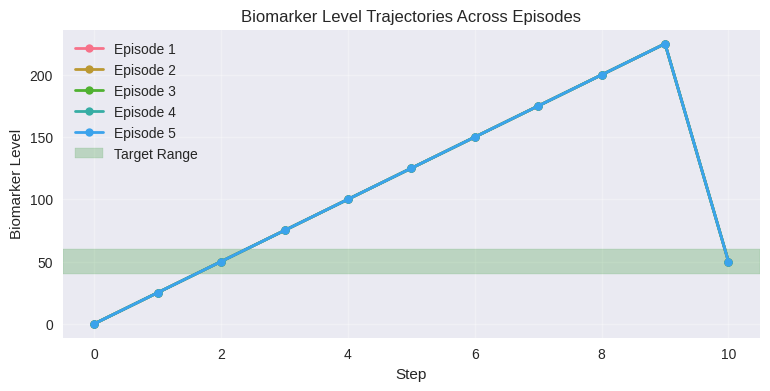


Final Policy Summary:
  State 0 (0.0): Recommend Increase
  State 1 (25.0): Recommend Increase
  State 2 (50.0): Recommend Maintain
  State 3 (75.0): Recommend Decrease
  State 4 (100.0): Recommend Decrease

Final Q-Table:
[[ 50.0538186   43.25378796  88.99999999]
 [ 77.50728205  84.07915471 100.        ]
 [ 89.         100.          89.        ]
 [100.          86.89001838  73.5426718 ]
 [ 88.99999999  54.80846466  39.32336609]]


In [ ]:
# Example 6: Biomarker Trajectories

def plot_biomarker_trajectory(num_episodes=5):
    """Plot the trajectory of biomarker levels during episodes."""
    # plt.figure(figsize=(12, 8))
    plt.figure(figsize=(9, 4))
    for episode in range(num_episodes):
        reset_environment()  # Reset environment at start of each episode
        state = current_state

        trajectory = []

        # Run one episode
        for step in range(10):  # Maximum steps per episode
            action = choose_action(state)
            next_state, reward, done = step_environment(action)
            trajectory.append(step * (100 / (state_space_size - 1)) if state_space_size > 1 else 50)  # Simplified biomarker level
            state = next_state

        trajectory.append(state * (100 / (state_space_size - 1)) if state_space_size > 1 else 50)

        plt.plot(range(len(trajectory)), trajectory, marker='o', linewidth=2,
                markersize=6, label=f'Episode {episode + 1}')

    # Add target range
    plt.axhspan(target_range[0], target_range[1], alpha=0.2, color='green', label='Target Range')

    plt.xlabel('Step')
    plt.ylabel('Biomarker Level')
    plt.title('Biomarker Level Trajectories Across Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot biomarker trajectories
print("\nPlotting biomarker level trajectories...")
plot_biomarker_trajectory(num_episodes=5)

# Final evaluation
print("\nFinal Policy Summary:")
for state in range(state_space_size):
    action = np.argmax(q_table[state, :])
    biomarker_value = state * (100 / (state_space_size - 1))
    action_names = ['Decrease', 'Maintain', 'Increase']
    print(f"  State {state} ({biomarker_value:.1f}): Recommend {action_names[action]}")

# Display the Q-table
print("\nFinal Q-Table:")
print(q_table)

If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image07A.png)

# **Exercises**

### **Exercise 1: Setup and Imports**

For **Exercise 1** you are to change some the environmental parameters to see how these changes affect reinforcement learning.

Here are the specific environmental changes you need to make:
1. Change `target_range` from (40,60) to (35, 65)
2. Change `state_space_size` from 5 to 7.
3. Leave `action_space_size` at 3
4. Change the `intial_state_prob` from [0.1, 0.2, 0.4, 0.2, 0.1] to [0.2, 0.1, 0.2, 0.3, 0.1, 0.05, 0.05]



In [43]:
# Insert your code for Exercise 1 here

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set environmental parameters
print("Exercise 1: Environment Parameters")
target_range = (35, 65)      # Original: (40, 60)
state_space_size = 7         # Original: 5
action_space_size = 3        # Original: 3
initial_state_prob = [0.2, 0.1, 0.2, 0.3, 0.1, 0.05, 0.05]   # Original: [0.1, 0.2, 0.4, 0.2, 0.1]

# Set up initial state probability distribution
if initial_state_prob is None:
    initial_state_prob = np.ones(state_space_size) / state_space_size  # Uniform
else:
    initial_state_prob = np.array(initial_state_prob)
    initial_state_prob /= np.sum(initial_state_prob)  # Ensure normalization

print(f"Environment parameters - Target range: {target_range}")
print(f"State space size: {state_space_size}, Action space size: {action_space_size}")
print(f"Initial state probabilities: {initial_state_prob}")

# Initialize current state
current_state = int(np.random.choice(np.arange(state_space_size), p=initial_state_prob))

Exercise 1: Environment Parameters
Environment parameters - Target range: (35, 65)
State space size: 7, Action space size: 3
Initial state probabilities: [0.2  0.1  0.2  0.3  0.1  0.05 0.05]


### 1. Define the Environment (Exercise Version)

In [ ]:
print("\nExercise 2: Modify environment transitions")
def reset_environment():
    """Reset the environment to a random initial state."""
    global current_state
    current_state = int(np.random.choice(np.arange(state_space_size), p=initial_state_prob))
    return current_state

def step_environment(action):
    """
    Simulates the environment's response to an action. Returns next state, reward, and done flag.

    Exercise: Try changing how actions affect transitions:
    - Make action 0 decrease by 2 instead of 1
    - Add stochasticity (random chance) to state transitions
    """

    global current_state

    # Original deterministic implementation
    if action == 0:  # Decrease dosage
        next_state = max(0, current_state - 1)  # Exercise: Change this to subtract 2 instead
    elif action == 1: # Maintain dosage
        next_state = current_state
    else:  # Increase dosage
        next_state = min(state_space_size - 1, current_state + 1)  # Exercise: Make it add 2

    current_state = next_state

    def state_to_biomarker(state):
        """Maps a discrete state to a continuous biomarker value."""
        return (state / (state_space_size - 1)) * 100

    biomarker_value = state_to_biomarker(current_state)

    # Exercise: Modify reward function
    if target_range[0] <= biomarker_value <= target_range[1]:
        reward = 15  # Original was 10, exercise: Try different rewards
    else:
        reward = -2   # Original was -1

    done = False
    return next_state, reward, done

def state_to_biomarker(state):
    """Maps a discrete state to a continuous biomarker value."""
    return (state / (state_space_size - 1)) * 100

def render():
    """Prints the current state in a human-readable format."""
    biomarker_value = state_to_biomarker(current_state)
    print(f"Current Biomarker Level: {biomarker_value:.2f}")

# Test the environment
print("Testing environment...")
reset_environment()
action = 0  # Decrease dosage
next_state, reward, done = step_environment(action)
render()
print(f"Action: Decrease -> Next State: {next_state}, Reward: {reward}")


Exercise 2: Modify environment transitions
Testing environment...
Current Biomarker Level: 16.67
Action: Decrease -> Next State: 1, Reward: -2


2. Define the Agent (Q-learning)

In [ ]:
print("\nExercise 3: Modify agent learning parameters")
# Original Q-learning hyperparameters:
learning_rate = 0.1        # Original: 0.1, Try changing to 0.05 or 0.2
discount_factor = 0.9      # Original: 0.9, Try changing to 0.8 or 0.95
exploration_rate = 0.1     # Original: 0.1, Try changing to 0.3 or 0.01

class QLearningAgent:
    def __init__(self):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.training_history = []

    def choose_action(self, state):
        """Exercise: Implement epsilon-greedy policy"""
        if random.uniform(0, 1) < self.exploration_rate:
            # Explore: Choose a random action
            return random.choice(range(self.action_space_size))
        else:
            # Exploit: Choose the action with highest Q-value for current state
            # Exercise: Try modifying this to use softmax instead of argmax
            return np.argmax(self.q_table[state, :])

    def learn(self, state, action, reward, next_state):
        """Exercise: Update Q-table using Q-learning update rule"""
        best_next_action = np.argmax(self.q_table[next_state, :])

        # Exercise: Try different TD target calculations
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]

        # Update Q-value with learning rate
        self.q_table[state, action] += self.learning_rate * td_error

        # Store reward for visualization
        self.training_history.append(reward)

# Create agent
agent = QLearningAgent()
print(f"Created agent with parameters: lr={learning_rate}, gamma={discount_factor}, eps={exploration_rate}")


Exercise 3: Modify agent learning parameters
Created agent with parameters: lr=0.1, gamma=0.9, eps=0.1


### 3. Training Loop

In [ ]:
print("\nExercise 4: Modify training loop behavior")
def train_agent_with_visualization(num_episodes=1000):
    """Train the agent and track progress"""

    rewards_per_episode = []

    for episode in range(num_episodes):
        state = reset_environment()  # Reset environment at beginning of each episode
        total_reward = 0

        # Exercise: Change maximum steps per episode
        max_steps = 15  # Original was 10, try increasing to 20 or decreasing to 5

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done = step_environment(action)  # Take a step
            agent.learn(state, action, reward, next_state)      # Update Q-table

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

        if episode % 200 == 0:   # Exercise: Change frequency of updates (try 50 or 100)
            print(f"Episode: {episode}, Total Reward: {total_reward}")

    print("Training complete.")
    return rewards_per_episode

# Train agent
print("Starting training...")
rewards_history = train_agent_with_visualization(num_episodes=2000)  # Exercise: Try different number of episodes like 500 or 3000


Exercise 4: Modify training loop behavior
Starting training...
Episode: 0, Total Reward: 55
Episode: 200, Total Reward: 208
Episode: 400, Total Reward: 208
Episode: 600, Total Reward: 174
Episode: 800, Total Reward: 208
Episode: 1000, Total Reward: 225
Episode: 1200, Total Reward: 157
Episode: 1400, Total Reward: 191
Episode: 1600, Total Reward: 225
Episode: 1800, Total Reward: 174
Training complete.


4. Visualization Functions


Exercise 5: Modify visualization parameters


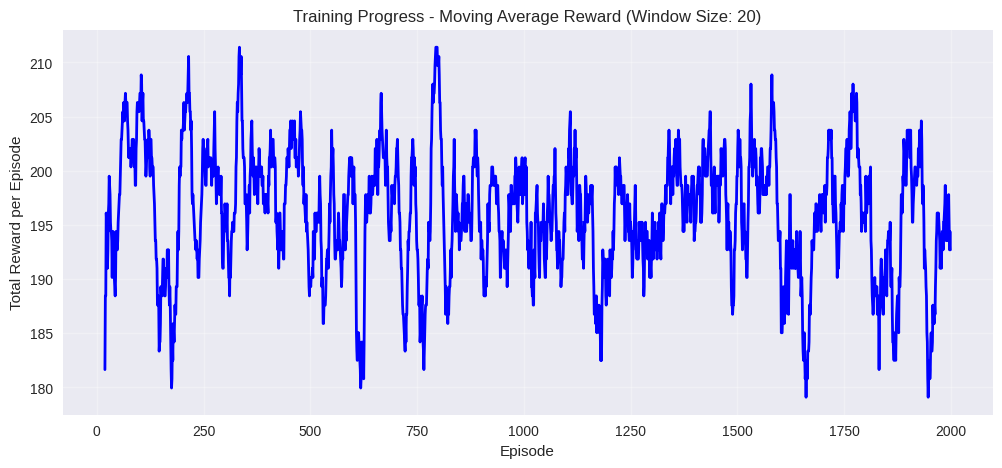

Exercise 6: Try different visualization styles


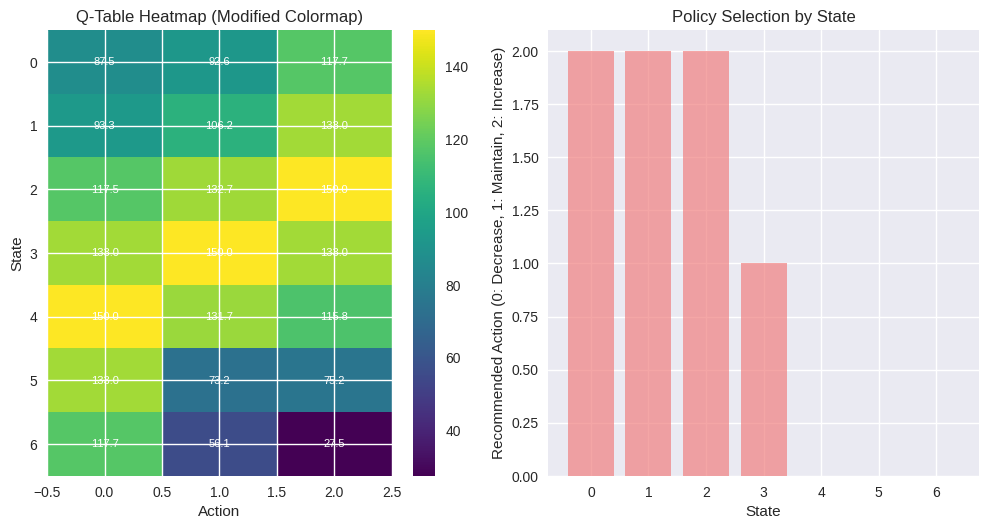

In [ ]:
print("\nExercise 5: Modify visualization parameters")
def plot_training_progress(rewards_history):
    """Plot training progress"""

    plt.figure(figsize=(12, 5))

    # Exercise: Try different window sizes for moving average
    window_size = 20  # Original was adaptive based on history length

    if len(rewards_history) >= window_size:
        moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(rewards_history)), moving_avg, 'b-', linewidth=2)
        plt.title('Training Progress - Moving Average Reward (Window Size: 20)')
    else:
        plt.plot(rewards_history, 'b-', linewidth=2)
        plt.title('Training Progress')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward per Episode')
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.show()

def visualize_policy_and_qtable():
    """Visualize learned policy and Q-table"""

    print("Exercise 6: Try different visualization styles")
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Q-Table Heatmap - Exercise try changing colormap
    ax1 = plt.subplot(2, 3, 1)
    q_table_array = np.array(agent.q_table)
    im = ax1.imshow(q_table_array, cmap='viridis', aspect='auto')   # Original was RdYlGn

    ax1.set_title('Q-Table Heatmap (Modified Colormap)')
    ax1.set_xlabel('Action')
    ax1.set_ylabel('State')

    for i in range(state_space_size):
        for j in range(action_space_size):
            ax1.text(j, i, f'{q_table_array[i,j]:.1f}',
                    ha='center', va='center', color='white' if q_table_array[i,j] > 0 else 'black', fontsize=8)

    plt.colorbar(im, ax=ax1)

    # Exercise: Add a second plot showing action selection probabilities
    ax2 = plt.subplot(2, 3, 2)
    policy_actions = []
    for i in range(state_space_size):
        best_action = np.argmax(agent.q_table[i, :])
        policy_actions.append(best_action)

    bars = ax2.bar(range(len(policy_actions)), policy_actions, color='lightcoral', alpha=0.7)
    ax2.set_xlabel('State')
    ax2.set_ylabel('Recommended Action (0: Decrease, 1: Maintain, 2: Increase)')
    ax2.set_title('Policy Selection by State')

    plt.tight_layout()
    plt.show()

# Run visualizations
plot_training_progress(rewards_history)
visualize_policy_and_qtable()

5. Additional Exercises



In [ ]:
print("\nExercise 7: Complete this function to implement a new reward structure")
def test_different_reward_functions():
    """Try different reward functions for the environment"""

    # Exercise: Implement alternative reward strategies:
    # - Reward based on how close biomarker is to target (not just in range)
    # - Penalty based on number of actions taken
    # - Different rewards for each action type

    print("Implementation complete!")

# Test your function
test_different_reward_functions()

print("\nExercise 8: Try different exploration strategies")
def adaptive_exploration():
    """Implement an adaptive epsilon decay strategy"""

    # Original: fixed exploration rate (0.1)
    # Exercise: Implement linear or exponential decay

    print("Original exploration rate:", agent.exploration_rate)
    print("Try implementing adaptive decay here!")

adaptive_exploration()

print("\nExercise 9: Modify the policy summary output")
def final_policy_summary():
    """Show what your trained agent learned"""

    action_names = ['Decrease', 'Maintain', 'Increase']

    for state in range(state_space_size):
        # Get best action according to current Q-table
        action = np.argmax(agent.q_table[state, :])
        biomarker_value = state_to_biomarker(state)

        # Exercise: Add information about confidence (difference between top 2 actions)
        print(f"State {state} ({biomarker_value:.1f}): Recommend {action_names[action]}")

    return "Policy summary completed with modifications!"

print(final_policy_summary())

# Show final Q-table
print("\nFinal Q-Table:")
print(agent.q_table)

print("\nExercise 10: Add a simple simulation test")
def simulate_single_episode():
    """Run one complete episode and show the trajectory"""

    reset_environment()
    state = current_state

    print(f"Starting Episode - Initial Biomarker Level: {state_to_biomarker(state):.2f}")

    # Run up to 10 steps
    for step in range(10):
        action = agent.choose_action(state)
        next_state, reward, done = step_environment(action)
        print(f"Step {step+1}: State {state} -> Action {action} -> Next State {next_state}")

        if state == next_state:
            print("  (No change in biomarker level)")
        else:
            new_biomarker = state_to_biomarker(next_state)
            print(f"  Biomarker changed from {state_to_biomarker(state):.2f} to {new_biomarker:.2f}")

        state = next_state

        # Stop early if target range achieved
        biomarker_value = state_to_biomarker(state)
        if target_range[0] <= biomarker_value <= target_range[1]:
            print(f"  Reached target range! Episode complete.")
            break

print("Running simulation test:")
simulate_single_episode()


Exercise 7: Complete this function to implement a new reward structure
Implementation complete!

Exercise 8: Try different exploration strategies
Original exploration rate: 0.1
Try implementing adaptive decay here!

Exercise 9: Modify the policy summary output
State 0 (0.0): Recommend Increase
State 1 (16.7): Recommend Increase
State 2 (33.3): Recommend Increase
State 3 (50.0): Recommend Maintain
State 4 (66.7): Recommend Decrease
State 5 (83.3): Recommend Decrease
State 6 (100.0): Recommend Decrease
Policy summary completed with modifications!

Final Q-Table:
[[ 87.52663913  92.57568464 117.7       ]
 [ 93.31008929 106.16406417 133.        ]
 [117.52731729 132.7044735  150.        ]
 [133.         150.         133.        ]
 [150.         131.69182238 115.81048704]
 [133.          73.22748555  75.2186063 ]
 [117.69892476  56.08576618  27.52480017]]

Exercise 10: Add a simple simulation test
Running simulation test:
Starting Episode - Initial Biomarker Level: 33.33
Step 1: State 2 -> 

## **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook if you are using a Mac. If you are using a Windows computer, then use the **File --> Print.. --> Microsoft Print to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_06_4.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.

## **Lizard Tail**

## **Women in Computing**


![__](https://upload.wikimedia.org/wikipedia/commons/a/ac/Marissa_Mayer_LeWeb_2008_VI.jpg)

#### **Former vice-president of Google Search Products and User Experience, former president and CEO of Yahoo!, Marissa Mayer**

"Tedious" computing and calculating was seen as "women's work" through the 1940s resulting in the term "kilogirl", invented by a member of the Applied Mathematics Panel in the early 1940s. A kilogirl of energy was "equivalent to roughly a thousand hours of computing labor." While women's contributions to the United States war effort during World War II was championed in the media, their roles and the work they did was minimized. This included minimizing the complexity, skill and knowledge needed to work on computers or work as human computers.[46] During WWII, women did most of the ballistics computing, seen by male engineers as being below their level of expertise. Black women computers worked as hard (or more often, even harder) as their white counterparts, but in segregated situations. By 1943, almost all people employed as computers were women; one report said "programming requires lots of patience, persistence and a capacity for detail and those are traits that many girls have".

NACA expanded its pool of women human computers in the 1940s. NACA recognized in 1942 that "the engineers admit themselves that the girl computers do the work more rapidly and accurately than they could." In 1943 two groups, segregated by race, worked on the east and west side of Langley Air Force Base.[51] The black women were the West Area Computers. Unlike their white counterparts, the black women were asked by NACA to re-do college courses they had already passed and many never received promotions.

Women were also working on ballistic missile calculations. In 1948, women such as Barbara Paulson were working on the WAC Corporal, determining trajectories the missiles would take after launch.

Women worked with cryptography and, after some initial resistance, many operated and worked on the Bombe machines. Joyce Aylard operated the Bombe machine testing different methods to break the Enigma code. Joan Clarke was a cryptographer who worked with her friend, Alan Turing, on the Enigma machine at Bletchley Park. When she was promoted to a higher salary grade, there were no positions in the civil service for a "senior female cryptanalyst," and she was listed as a linguist instead. While Clarke developed a method of increasing the speed of double-encrypted messages, unlike many of the men, her decryption technique was not named after her. Other cryptographers at Bletchley included Margaret Rock, Mavis Lever (later Batey), Ruth Briggs and Kerry Howard. In 1941, Batey's work enabled the Allies to break the Italians' naval code before the Battle of Cape Matapan. In the United States, several faster Bombe machines were created. Women, like Louise Pearsall, were recruited from the WAVES to work on code breaking and operate the American Bombe machines.

Hedy Lamarr and co-inventor, George Antheil, worked on a frequency hopping method to help the Navy control torpedoes remotely. The Navy passed on their idea, but Lamarr and Antheil received a patent for the work on August 11, 1942. This technique would later be used again, first in the 1950s at Sylvania Electronic Systems Division and is used in everyday technology such as Bluetooth and Wi-Fi.

Marlyn Wescoff, standing, and Ruth Lichterman reprogram the ENIAC in 1946.
Marlyn Wescoff (standing) and Ruth Lichterman reprogram the ENIAC in 1946
The programmers of the ENIAC computer in 1944, were six female mathematicians; Marlyn Meltzer, Betty Holberton, Kathleen Antonelli, Ruth Teitelbaum, Jean Bartik, and Frances Spence, who were human computers at the Moore School's computation lab.[63] Adele Goldstine was their teacher and trainer and they were known as the "ENIAC girls." The women who worked on ENIAC were warned that they would not be promoted into professional ratings which were only for men.[66] Designing the hardware was "men's work" and programming the software was "women's work."[67] Sometimes women were given blueprints and wiring diagrams to figure out how the machine worked and how to program it. They learned how the ENIAC worked by repairing it, sometimes crawling through the computer, and by fixing "bugs" in the machinery.[68] Even though the programmers were supposed to be doing the "soft" work of programming, in reality, they did that and fully understood and worked with the hardware of the ENIAC. When the ENIAC was revealed in 1946, Goldstine and the other women prepared the machine and the demonstration programs it ran for the public. None of their work in preparing the demonstrations was mentioned in the official accounts of the public events. After the demonstration, the university hosted an expensive celebratory dinner to which none of the ENIAC six were invited.

In Canada, Beatrice Worsley started working at the National Research Council of Canada in 1947 where she was an aerodynamics research officer.[73] A year later, she started working in the new Computational Centre at the University of Toronto.[73] She built a differential analyzer in 1948 and also worked with IBM machines in order to do calculations for Atomic Energy of Canada Limited. She went to study the EDSAC at the University of Cambridge in 1949. She wrote the program that was run the first time EDSAC performed its first calculations on May 6, 1949.

Grace Hopper was the first person to create a compiler for a programming language and one of the first programmers of the Harvard Mark I computer, an electro-mechanical computer based on Analytical Engine. Hopper's work with computers started in 1943, when she started working at the Bureau of Ordnance's Computation Project at Harvard where she programmed the Harvard Mark I.[49] Hopper not only programmed the computer, but created a 500-page comprehensive manual for it.[75] Even though Hopper created the manual, which was widely cited and published, she was not specifically credited in it. Hopper is often credited with the coining of the term "bug" and "debugging" when a moth caused the Mark II to malfunction. While a moth was found and the process of removing it called "debugging," the terms were already part of the language of programmers.

**1950s**

Grace Hopper continued to contribute to computer science through the 1950s. She brought the idea of using compilers from her time at Harvard to UNIVAC which she joined in 1949. Other women who were hired to program UNIVAC included Adele Mildred Koss, Frances E. Holberton, Jean Bartik, Frances Morello and Lillian Jay. To program the UNIVAC, Hopper and her team used the FLOW-MATIC programming language, which she developed. Holberton wrote a code, C-10, that allowed for keyboard inputs into a general-purpose computer. Holberton also developed the Sort-Merge Generator in 1951 which was used on the UNIVAC I. The Sort-Merge Generator marked the first time a computer "used a program to write a program." Holberton suggested that computer housing should be beige or oatmeal in color which became a long-lasting trend. Koss worked with Hopper on various algorithms and a program that was a precursor to a report generator.

Klara Dan von Neumann was one of the main programmers of the MANIAC, a more advanced version of ENIAC. Her work helped the field of meteorology and weather prediction.

The NACA, and subsequently NASA, recruited women computers following World War II.[43] By the 1950s, a team was performing mathematical calculations at the Lewis Research Center in Cleveland, Ohio, including Annie Easley, Katherine Johnson and Kathryn Peddrew. At the National Bureau of Standards, Margaret R. Fox was hired to work as part of the technical staff of the Electronic Computer Laboratory in 1951. In 1956, Gladys West was hired by the U.S. Naval Weapons Laboratory as a human computer. West was involved in calculations that let to the development of GPS.

At Convair Aircraft Corporation, Joyce Currie Little was one of the original programmers for analyzing data received from the wind tunnels. She used punch cards on an IBM 650 which was located in a different building from the wind tunnel. To save time in the physical delivery of the punch cards, she and her colleague, Maggie DeCaro, put on roller skates to get to and from the building faster.

In Israel, Thelma Estrin worked on the design and development of WEIZAC, one of the world's first large-scale programmable electronic computers. In the Soviet Union a team of women helped design and build the first digital computer in 1951. In the UK, Kathleen Booth worked with her husband, Andrew Booth on several computers at Birkbeck College. Kathleen Booth was the programmer and Andrew built the machines. Kathleen developed Assembly Language at this time.

**1960s**

![__](https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Margaret_Hamilton_-_restoration.jpg/1920px-Margaret_Hamilton_-_restoration.jpg)

### **Margaret Hamilton in 1969, standing next to listings of the software she and her MIT team produced for the Apollo project**

PFC Patricia Barbeau operates a tape-drive on the IBM 729 at Camp Smith.
PFC Patricia Barbeau operates a tape-drive on the IBM 729 at Camp Smith.
Milly Koss who had worked at UNIVAC with Hopper, started work at Control Data Corporation (CDC) in 1965. There she developed algorithms for graphics, including graphic storage and retrieval.

Mary K. Hawes of Burroughs Corporation set up a meeting in 1959 to discuss the creation a computer language that would be shared between businesses. Six people, including Hopper, attended to discuss the philosophy of creating a common business language (CBL). Hopper became involved in developing COBOL (Common Business Oriented Language) where she innovated new symbolic ways to write computer code. Hopper developed programming language that was easier to read and "self-documenting." After COBOL was submitted to the CODASYL Executive Committee, Betty Holberton did further editing on the language before it was submitted to the Government Printing Office in 1960. IBM were slow to adopt COBOL, which hindered its progress but it was accepted as a standard in 1962, after Hopper had demonstrated the compiler working both on UNIVAC and RCA computers. The development of COBOL led to the generation of compilers and generators, most of which were created or refined by women such as Koss, Nora Moser, Deborah Davidson, Sue Knapp, Gertrude Tierney and Jean E. Sammet.

Sammet, who worked at IBM starting in 1961 was responsible for developing the programming language, FORMAC.[96] She published a book, Programming Languages: History and Fundamentals (1969), which was considered the "standard work on programming languages," according to Denise Gürer. It was "one of the most used books in the field," according to The Times in 1972.

Between 1961 and 1963, Margaret Hamilton began to study software reliability while she was working at the US SAGE air defense system. In 1965, she was responsible for programming the software for the onboard flight software on the Apollo mission computers. After Hamilton had completed the program, the code was sent to Raytheon where "expert seamstresses" called the "Little Old Ladies" actually hardwired the code by threading copper wire through magnetic rings. Each system could store more than 12,000 words that were represented by the copper wires.

In 1964, the British Prime Minister Harold Wilson announced a "White-Hot" revolution in technology, that would give greater prominence to IT work. As women still held most computing and programming positions at this time, it was hoped that it would give them more positive career prospects. In 1965, Sister Mary Kenneth Keller became the first American woman to earn a doctorate in computer science. Keller helped develop BASIC while working as a graduate student at Dartmouth, where the university "broke the 'men only' rule" so she could use its computer science center.

In 1966, Frances "Fran" Elizabeth Allen who was developing programming language compilers at IBM Research, published a paper entitled "Program Optimization,". It laid the conceptual basis for systematic analysis and transformation of computer programs. This paper introduced the use of graph-theoretic structures to encode program content in order to automatically and efficiently derive relationships and identify opportunities for optimization.

Christine Darden began working for NASA's computing pool in 1967 having graduated from the Hampton Institute. Women were involved in the development of Whirlwind, including Judy Clapp. She created the prototype for an air defense system for Whirlwind which used radar input to track planes in the air and could direct aircraft courses.

In 1969, Elizabeth "Jake" Feinler, who was working for Stanford, made the first Resource Handbook for ARPANET. This led to the creation of the ARPANET directory, which was built by Feinler with a staff of mostly women. Without the directory, "it was nearly impossible to navigate the ARPANET."

By the end of the decade, the general demographics of programmers had shifted away from being predominantly women, as they had before the 1940s. Though women accounted for around 30 to 50 percent of computer programmers during the 1960s, few were promoted to leadership roles and women were paid significantly less than their male counterparts. Cosmopolitan ran an article in the April 1967 issue about women in programming called "The Computer Girls." Even while magazines such as Cosmopolitan saw a bright future for women in computers and computer programming in the 1960s, the reality was that women were still being marginalized.

**1970s**

In the early 1970s, Pam Hardt-English led a group to create a computer network they named Resource One and which was part of a group called Project One.[117] Her idea to connect Bay Area bookstores, libraries and Project One was an early prototype of the Internet. To work on the project, Hardt-English obtained an expensive SDS-940 computer as a donation from TransAmerica Leasing Corporation in April 1972.They created an electronic library and housed it in a record store called Leopold's in Berkeley. This became the Community Memory database and was maintained by hacker Jude Milhon. After 1975, the SDS-940 computer was repurposed by Sherry Reson, Mya Shone, Chris Macie and Mary Janowitz to create a social services database and a Social Services Referral Directory. Hard copies of the directory, printed out as a subscription service, were kept at city buildings and libraries. The database was maintained and in use until 2009.

In the early 1970s, Elizabeth "Jake" Feinler, who worked on the Resource Directory for ARPANET, and her team created the first WHOIS directory. Feinler set up a server at the Network Information Center (NIC) at Stanford which would work as a directory that could retrieve relevant information about a person or entity. She and her team worked on the creation of domains, with Feinler suggesting that domains be divided by categories based on where the computers were kept. For example, military computers would have the domain of .mil, computers at educational institutions would have .edu. Feinler worked for NIC until 1989.

Adele Goldberg was one of seven programmers that developed Smalltalk in the 1970s, and wrote the majority of the language's documentation. It was one of the first object-oriented programming languages the base of the current graphic user interface, that has its roots in the 1968 The Mother of All Demos by Douglas Engelbart. Smalltalk was used by Apple to launch Apple Lisa in 1983, the first personal computer with a GUI, and a year later its Macintosh. Windows 1.0, based on the same principles, was launched a few months later in 1985.

In the late 1970s, women such as Paulson and Sue Finley wrote programs for the Voyager mission. Voyager continues to carry their codes inside its own memory banks as it leaves the solar system. In 1979, Ruzena Bajcsy founded the General Robotics, Automation, Sensing and Perception (GRASP) Lab at the University of Pennsylvania.

In the mid-70s, Joan Margaret Winters began working at IBM as part of a "human factors project," called SHARE. In 1978, Winters was the deputy manager of the project and went on to lead the project between 1983 and 1987. The SHARE group worked on researching how software should be designed to consider human factors.

**1980s**

In 1981, Deborah Washington Brown became the first African American woman to earn a Ph.D. in computer science from Harvard University (at the time the degree was part of the applied mathematics program). Her thesis was titled "The solution of difference equations describing array manipulation in program loops". Shortly after, in 1982, Marsha R. Williams became the second African American woman to earn a Ph.D. in computer science.

Sometimes known as the "Betsy Ross of the personal computer," according to the New York Times, Susan Kare worked with Steve Jobs to design the original icons for the Macintosh. Kare designed the moving watch, paintbrush and trash can elements that made using a Mac user-friendly. Kare worked for Apple until the mid-1980s, going on to work on icons for Windows 3.0. Other types of computer graphics were being developed by Nadia Magnenat Thalmann in Canada. Thalmann started working on computer animation to develop "realistic virtual actors" first at the University of Montréal in 1980 and later in 1988 at the École Polytechnique Fédérale de Lausanne.

Computer and video games became popular in the 1980s, but many were primarily action-oriented and not designed from a woman's point of view. Stereotypical characters such as the damsel in distress featured prominently and consequently were not inviting towards women. Dona Bailey designed Centipede, where the player shoots insects, as a reaction to such games, later saying "It didn't seem bad to shoot a bug". Carol Shaw, considered to be the first modern female games designer, released a 3D version of tic-tac-toe for the Atari 2600 in 1980.Roberta Williams and her husband Ken, founded Sierra Online and pioneered the graphic adventure game format in Mystery House and the King's Quest series. The games had a friendly graphical user interface and introduced humor and puzzles. Cited as an important game designer, her influence spread from Sierra to other companies such as LucasArts and beyond. Brenda Laurel ported games from arcade versions to the Atari 8-bit computers in the late 1970s and early 1980s. She then went to work for Activision and later wrote the manual for Maniac Mansion.

1984 was the year of Women into Science and Engineering (WISE Campaign). A 1984 report by Ebury Publishing reported that in a typical family, only 5% of mothers and 19% of daughters were using a computer at home, compared to 25% of fathers and 51% of sons. To counteract this, the company launched a series of software titles designed towards women and publicized in Good Housekeeping.[146] Anita Borg, who had been noticing that women were under-represented in computer science, founded an email support group, Systers, in 1987.

As Ethernet became the standard for networking computers locally, Radia Perlman, who worked at Digital Equipment Corporation (DEC), was asked to "fix" limitations that Ethernet imposed on large network traffic. In 1985, Perlman came up with a way to route information packets from one computer to another in an "infinitely scalable" way that allowed large networks like the Internet to function.Her solution took less than a few days to design and write up. The name of the algorithm she created is the Spanning Tree Protocol. In 1986, Lixia Zhang was the only woman and graduate student to participate in the early Internet Engineering Task Force (IETF) meetings. Zhang was involved in early Internet development.

In Europe, project was developed in the mid-1980s to create an academic network in Europe using the Open System Interconnection (OSI) standards. Borka Jerman Blažič, a Yugoslavian computer scientist was invited to work on the project. She was involved in establishing a Yugoslav Research and Academic Network (YUNAC) in 1989 and registered the domain of .yu for the country.

In the field of human–computer interaction (HCI), French computer scientist, Joëlle Coutaz developed the presentation-abstraction-control (PAC) model in 1987.[152][153] She founded the User Interface group at the Laboratorire de Génie Informatique of IMAG where they worked on different problems relating to user interface and other software tools.

In 1988, Stacy Horn, who had been introduced to bulletin board systems (BBS) through The WELL, decided to create her own online community in New York, which she called the East Coast Hang Out (ECHO).Horn invested her own money and pitched the idea for ECHO to others after bankers refused to hear her business plan. Horn built her BBS using UNIX, which she and her friends taught to one another.Eventually ECHO moved an office in Tribeca in the early 1990s and started getting press attention. ECHO's users could post about topics that interested them, and chat with one another, and were provided email accounts. Around half of ECHO's users were women. ECHO was still online as of 2018.

**1990s**

By the 1990s, computing was dominated by men. The proportion of female computer science graduates peaked in 1984 around 37 per cent, and then steadily declined.[162] Although the end of the 20th century saw an increase in women scientists and engineers, this did not hold true for computing, which stagnated.[163] Despite this, they were very involved in working on hypertext and hypermedia projects in the late 1980s and early 1990s. A team of women at Brown University, including Nicole Yankelovich and Karen Catlin, developed Intermedia and invented the anchor link. Apple partially funded their project and incorporated their concepts into Apple operating systems. Sun Microsystems Sun Link Service was developed by Amy Pearl. Janet Walker developed the first system to use bookmarks when she created the Symbolics Document Examiner. In 1989, Wendy Hall created a hypertext project called Microcosm, which was based on digitized multimedia material found in the Mountbatten archive. Cathy Marshall worked on the NoteCards system at Xerox PARC. NoteCards went on to influence Apple's HyperCard. As the Internet became the World Wide Web, developers like Hall adapted their programs to include Web viewers. Her Microcosm was especially adaptable to new technologies, including animation and 3-D models. In 1994, Hall helped organize the first conference for the Web.

Following the increased popularity of the Internet in the 1990s, online spaces were set up to cater for women, including the online community Women's WIRE and the technical and support forum LinuxChix. Women's WIRE, launched by Nancy Rhine and Ellen Pack in October 1993, was the first Internet company to specifically target this demographic. A conference for women in computer-related jobs, the Grace Hopper Celebration of Women in Computing, was first launched in 1994 by Anita Borg.

Game designer Brenda Laurel started working at Interval Research in 1992, and began to think about the differences in the way girls and boys experienced playing video games. After interviewing around 1,000 children and 500 adults, she determined that games weren't designed with girls' interests in mind.[178] The girls she spoke with wanted more games with open worlds and characters they could interact with. Her research led to Interval Research giving Laurel's research team their own company in 1996, Purple Moon. Also in 1996, Mattel's game, Barbie Fashion Designer, became the first best-selling game for girls. Purple Moon's first two games based on a character called Rockett, made it to the 100 best-selling games in the years they were released. In 1999, Mattel bought out Purple Moon.


![__](https://upload.wikimedia.org/wikipedia/commons/4/40/Jaimelevyrussell.jpg)

### **Jaime Levy helped popularise the e-Zine in the 1990s**

Jaime Levy created one of the first e-Zines in the early 1990s, starting with CyberRag, which included articles, games and animations loaded onto diskettes that anyone with a Mac could access. Later, she renamed the zine to Electronic Hollywood.Billy Idol commissioned Levy to create a disk for his album, Cyberpunk. She was hired to be the creative director of the online magazine, Word, in 1995.

Cyberfeminists, VNS Matrix, made up of Josephine Starrs, Juliane Pierce, Francesca da Rimini and Virginia Barratt, created art in the early 1990s linking computer technology and women's bodies. In 1997, there was a gathering of cyberfeminists in Kassel, called the First Cyberfeminist International.

In China, Hu Qiheng, was the leader of the team who installed the first TCP/IP connection for China, connecting to the Internet on April 20, 1994. In 1995, Rosemary Candlin went to write software for CERN in Geneva. In the early 1990s, Nancy Hafkin was an important figure in working with the Association for Progressive Communications (APC) in enabling email connections in 10 African countries. Starting in 1999, Anne-Marie Eklund Löwinder began to work with Domain Name System Security Extensions (DNSSEC) in Sweden.[189] She later made sure that the domain, .se, was the world's first top level domain name to be signed with DNSSEC.

From the late 1980s until the mid-1990s, Misha Mahowald developed several key foundations of the field of Neuromorphic engineering, while working at the California Institute of Technology and later at the ETH Zurich. More than 20 years after her untimely death, the Misha Mahowald Prize was named after her to recognize excellence in the field which she helped to create.

**2000s**

In the 21st century, several attempts have been made to reduce the gender disparity in IT and get more women involved in computing again. A 2001 survey found that while both sexes use computers and the internet in equal measure, women were still five times less likely to choose it as a career or study the subject beyond standard secondary education. Journalist Emily Chang said a key problem has been personality tests in job interviews and the belief that good programmers are introverts, which tends to self-select the stereotype of an asocial white male nerd.

In 2004, the National Center for Women & Information Technology was established by Lucy Sanders to address the gender gap.[194] Carnegie Mellon University has made a concerted attempt to increase gender diversity in the computer science field, by selecting students based on a wide criteria including leadership ability, a sense of "giving back to the community" and high attainment in maths and science, instead of traditional computer programming expertise. As well as increase the intake of women into CMU, the programme produced better quality students because of the increased diversity making a stronger team.

**2010s**

Despite the pioneering work of some designers, video games are still considered biased towards men. A 2013 survey by the International Game Developers Association revealed only 22% of game designers are women, although this is substantially higher than figures in previous decades. Working to bring inclusion to the world of open source project development, Coraline Ada Ehmke drafted the Contributor Covenant in 2014. By 2018, over 40,000 software projects have started using the Contributor Covenant, including TensorFlow, Vue and Linux. In 2014, Danielle George, professor at the School of Electrical and Electronic Engineering, University of Manchester spoke at the Royal Institution Christmas Lectures on the subject of "how to hack your home", describing simple experiments involving computer hardware and demonstrating a giant game of Tetris by remote controlling lights in an office building.

In 2017, Michelle Simmons founded the first quantum computing company in Australia.[199] The team, which has made "great strides" in 2018, plans to develop a 10-qubit prototype silicon quantum integrated circuit by 2022. In the same year, Doina Precup became the head of DeepMind Montreal, working on artificial intelligence. Xaviera Kowo is a programmer from Cameroon, who won the Margaret award, for programming a robot which processes waste in 2022.

**2020s**

In 2023 the EU-Startups the leading online publication with a focus on startups in Europe published the list of top 100 of the most influential women in the startup and venture capital space in Europe.[202] The theme of the list reflects the era of innovation and technological change. That being said, there are plenty of inspiring women in Europe's startup and all around the world in VC space who are making daily changes possible and encouraging a new generation of female for entrepreneurship and innovation.